In [1]:
!pip install torchmetrics
import torch
import random
from tqdm.notebook import tqdm
from torch import nn
from timeit import default_timer as timer
from torchmetrics import Accuracy
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules import padding
from torch.nn.modules.conv import Conv2d
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 7.7 MB/s eta 0:00:00


Getting the dataset


In [2]:
train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = ToTensor(), target_transform = None )
test_data = datasets.FashionMNIST(root = 'data' , train = False , download = True, transform= ToTensor(), target_transform = None )
classes_names = train_data.classes

100%|██████████| 26421880/26421880 [00:02<00:00, 12596851.94it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210167.72it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3945500.52it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21399679.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Seeing a random images

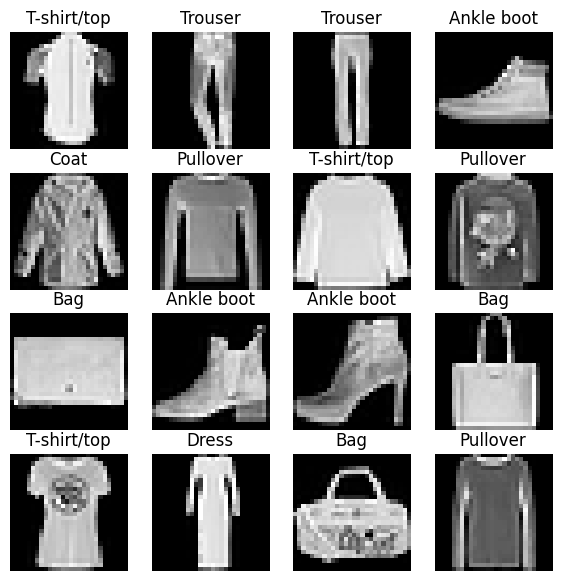

In [3]:

fig = plt.figure(figsize=(7,7) )
for i in range(1,17,1):
    random_idx = torch.randint(0, len(train_data), (1,) ).item()
    img, label = train_data[random_idx]
    fig.add_subplot(4,4,i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title( classes_names[label] )
    plt.axis(False)

Prepare DataLoader -> into Batches


In [4]:
torch.manual_seed(40)


train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size= 32 , shuffle = False)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [5]:
torch.manual_seed(40)

class Fashion_MNIST(nn.Module):
    def __init__(self, inp, hidden_units, oup):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels= inp, out_channels= hidden_units, kernel_size=3 ,stride =1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size=3, padding=1, stride = 1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            )

        self.block2 =nn.Sequential(
            nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
             )

        self.classifier= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 49 , out_features=oup)
            )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x




In [6]:
torch.manual_seed(40)

model0 = Fashion_MNIST(1, 256 , len(classes_names)).to(device)


In [7]:
torch.manual_seed(40)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(), lr = 0.01 )


In [8]:
torch.manual_seed(40)

def trainStep(model, dataloader, lossfn, optimizer):
    train_loss, train_acc = 0,0
    accuracy = Accuracy(task="multiclass", num_classes=len(classes_names)).to(device)
    for batch, (x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss_fn = lossfn(y_pred, y)
        train_loss += loss_fn
        train_acc  += accuracy(y_pred.argmax(dim =1), y)
        optimizer.zero_grad()
        loss_fn.backward()
        optimizer.step()

    train_loss = train_loss/ len(dataloader)
    train_acc = train_acc/ len(dataloader)
    print(f'Train Loss: {train_loss:.4f}  | Train Accuracy : {train_acc:.4f}')

    return train_loss , train_acc


In [9]:
torch.manual_seed(40)

def testStep(model, dataloader, loss_fn):
    test_loss, test_acc = 0, 0
    accuracy = Accuracy(task="multiclass", num_classes=len(classes_names)).to(device)
    model.eval()
    with torch.inference_mode():
        for x , y in dataloader:
            x = x.to(device)
            y = y.to(device)
            test_pred = model(x)
            test_loss += loss_fn(test_pred ,y )
            test_acc  += accuracy(test_pred.argmax(dim = 1) , y)

    test_loss = test_loss/ len(dataloader)
    test_acc = test_acc/ len(dataloader)


    print(f'Test Loss: {test_loss:.4f}  | Test Accuracy : {test_acc:.4f}')
    return test_loss, test_acc


In [10]:
torch.manual_seed(40)

trainTimeS = timer()
epochs = 50
ep = []
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []

for e in tqdm(range(epochs)):
    print(f'\n ============= \n Epoch: {e}\n')
    tr_loss, tr_acc = trainStep(dataloader= train_dataloader, model = model0, lossfn = loss_fn,  optimizer = optimizer )
    t , ac = testStep(dataloader= test_dataloader, model = model0, loss_fn = loss_fn)

    test_loss_list.append(t.cpu().numpy().tolist())
    test_accuracy_list.append(ac.cpu().numpy().tolist())

    train_loss_list.append(tr_loss.cpu().detach().numpy().tolist())
    train_accuracy_list.append(tr_acc.cpu().detach().numpy().tolist())

    ep.append(e)



TrainTimeE = timer()
totalTime  = TrainTimeE - trainTimeS

print(f'==== The Total Time is: {totalTime:.1f} Sec  ======= ')





  0%|          | 0/50 [00:00<?, ?it/s]


 Epoch: 0

Train Loss: 0.7076  | Train Accuracy : 0.7492
Test Loss: 0.4489  | Test Accuracy : 0.8383

 Epoch: 1

Train Loss: 0.3998  | Train Accuracy : 0.8549
Test Loss: 0.3980  | Test Accuracy : 0.8531

 Epoch: 2

Train Loss: 0.3420  | Train Accuracy : 0.8768
Test Loss: 0.3503  | Test Accuracy : 0.8770

 Epoch: 3

Train Loss: 0.3093  | Train Accuracy : 0.8887
Test Loss: 0.3208  | Test Accuracy : 0.8879

 Epoch: 4

Train Loss: 0.2866  | Train Accuracy : 0.8972
Test Loss: 0.3082  | Test Accuracy : 0.8889

 Epoch: 5

Train Loss: 0.2681  | Train Accuracy : 0.9029
Test Loss: 0.3066  | Test Accuracy : 0.8859

 Epoch: 6

Train Loss: 0.2532  | Train Accuracy : 0.9085
Test Loss: 0.2842  | Test Accuracy : 0.8983

 Epoch: 7

Train Loss: 0.2398  | Train Accuracy : 0.9138
Test Loss: 0.2737  | Test Accuracy : 0.9018

 Epoch: 8

Train Loss: 0.2293  | Train Accuracy : 0.9172
Test Loss: 0.2623  | Test Accuracy : 0.9036

 Epoch: 9

Train Loss: 0.2183  | Train Accuracy : 0.9209
Test Loss: 0.2555  | Tes

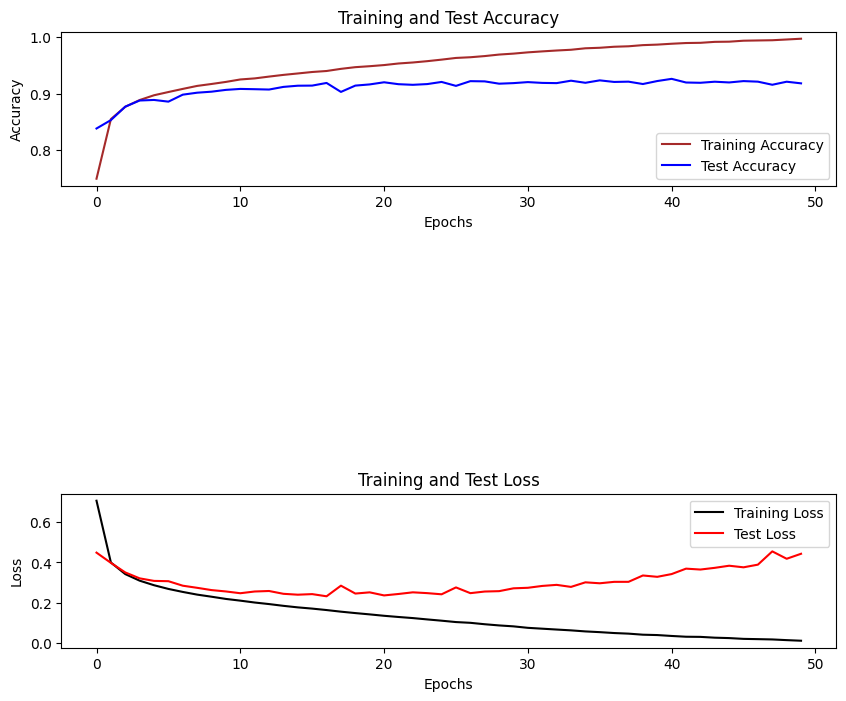

In [11]:
torch.manual_seed(40)

plt.subplot(2, 1, 1)
plt.plot(ep, train_accuracy_list, 'brown', label='Training Accuracy')
plt.plot(ep, test_accuracy_list, 'b', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ep, train_loss_list, 'black', label='Training Loss')
plt.plot(ep, test_loss_list, 'r', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplots_adjust(hspace=2)
plt.gcf().set_size_inches(10, 8)

plt.show()


In [12]:
torch.manual_seed(40)

def make_predictions(model, data):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [24]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[7].shape}\nTest sample label: {test_labels[7]} ({classes_names[test_labels[7]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 9 (Ankle boot)


In [25]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model0,data=test_samples)

# View first two prediction probabilities list
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 0, 3, 3, 3, 6, 0, 9, 4], device='cuda:0')

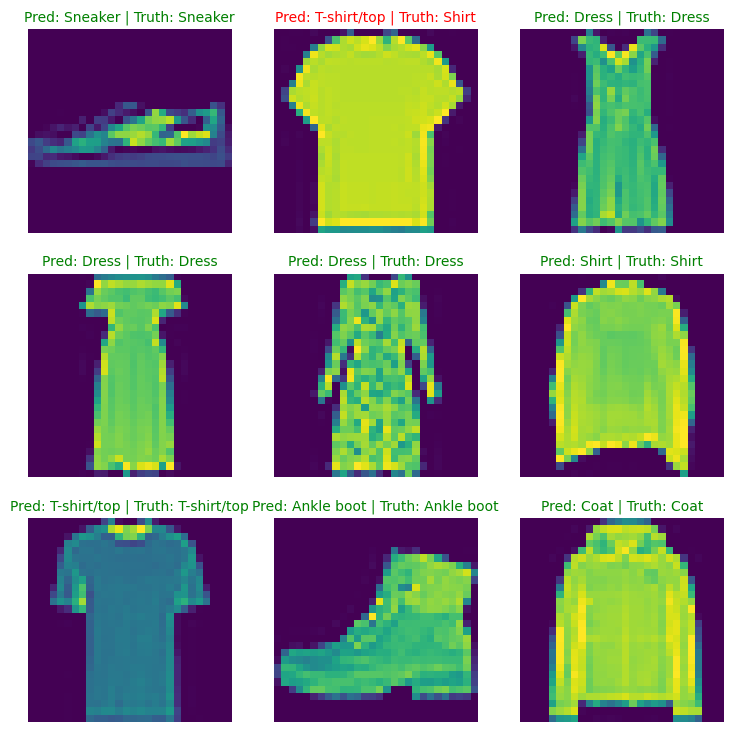

In [26]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze())

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [16]:
# Import tqdm for progress bar

# 1. Make predictions with trained model
y_preds = []
model0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    # Send data and targets to target device
    # Do the forward pass
    y_logit = model0(X.to(device)).to(device)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [17]:
len(y_pred_tensor)


10000

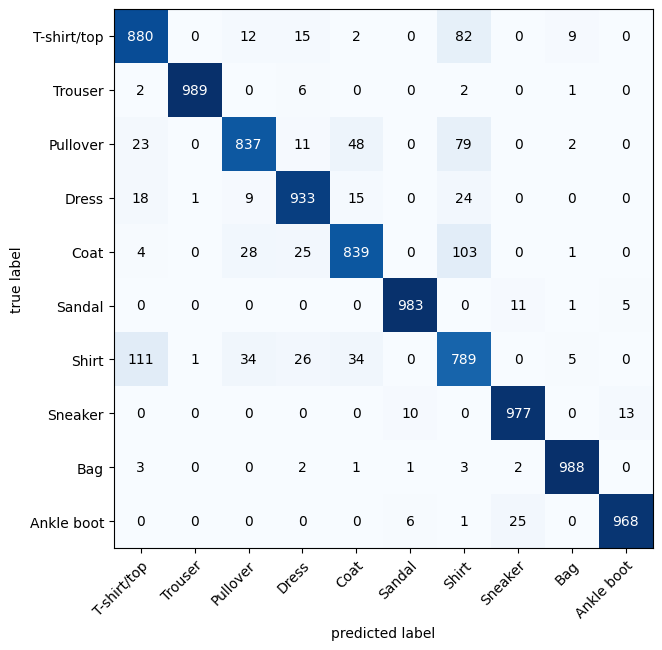

In [18]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [19]:
# Specify a path
PATH = "state_dict_model.pt"

# Save
torch.save(model0.state_dict(), PATH)

# Load


#model = Fashion_MNIST(inp=1, hidden_units=20, oup=len(classes_names))
#model.load_state_dict(torch.load(PATH))
#model.eval()
#model.state_dict()


In [28]:
print(python.__version__)


NameError: ignored